In [106]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import torch
import random

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return

seed_everything(42)


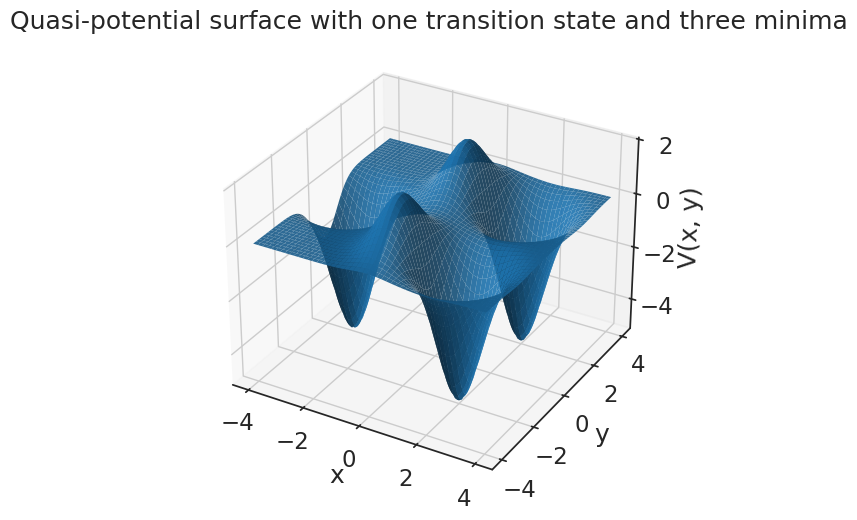

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Quasi‑potential definition (modified two‑barrier + three wells) ----
B = 2.0
sx = sy = 0.6
well_depth = 5.0
s_well = 0.7
wells = [(-3.0, 0.0), (2.0, 2.0), (2.0, -2.0)]
two_sx2 = 2 * sx**2
two_sy2 = 4 * sy**2
two_sw2 = 2 * s_well**2

def V(x, y):
    """Quasi‑potential with one central transition state and three minima."""
    # central barrier (positive)
    barrier1 = B * np.exp(-(x ** 2 / two_sx2 + (y+2) ** 2 / two_sy2))
    barrier2 = B * np.exp(-(x ** 2 / two_sx2 + (y-2) ** 2 / two_sy2))
    barrier = barrier1 + barrier2
    # three Gaussian wells (negative)
    wells_sum = 0.0
    for xi, yi in wells:
        wells_sum -= well_depth * np.exp(-((x - xi) ** 2 + (y - yi) ** 2) / two_sw2)

    return barrier + wells_sum


def grad_V(x, y):
    """Analytic gradient of the quasi‑potential."""
    # gradient of central barrier
    e_barrier = np.exp(-(x ** 2 / two_sx2 + y ** 2 / two_sy2))
    dVdx = B * e_barrier * (-2 * x / two_sx2)
    dVdy = B * e_barrier * (-2 * y / two_sy2)

    # gradients of wells
    for xi, yi in wells:
        e_well = np.exp(-((x - xi) ** 2 + (y - yi) ** 2) / two_sw2)
        dVdx += well_depth * e_well * (2 * (x - xi) / two_sw2)
        dVdy += well_depth * e_well * (2 * (y - yi) / two_sw2)

    return dVdx, dVdy


# --- Plot the 3‑D surface ------------------------------------------------------
x = np.linspace(-4, 4, 400)
y = np.linspace(-4, 4, 400)
X, Y = np.meshgrid(x, y)
Z = V(X, Y)

fig1 = plt.figure(figsize=(8, 6))
ax = fig1.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True, alpha=0.9)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("V(x, y)")
ax.set_title("Quasi‑potential surface with one transition state and three minima")

# --- Integrate gradient‑descent trajectories -----------------------------------
def integrate_path(x0, y0, step=0.02, max_iter=1000, tol=1e-3):
    xs, ys = [x0], [y0]
    for _ in range(max_iter):
        gx, gy = grad_V(xs[-1], ys[-1])
        g_norm = np.hypot(gx, gy)
        if g_norm < tol:
            break
        xs.append(xs[-1] - step * gx)
        ys.append(ys[-1] - step * gy)
    return np.array(xs), np.array(ys)

# Seed points placed on a small circle around the central barrier
theta = np.linspace(0, 2 * np.pi, 20, endpoint=False)
seeds = np.stack([0.2 * np.cos(theta), 0.2 * np.sin(theta)], axis=1)

# Compute paths
paths = [integrate_path(x0, y0) for x0, y0 in seeds]


step_0: (300, 2)
step_200: (300, 2)
step_300: (300, 2)


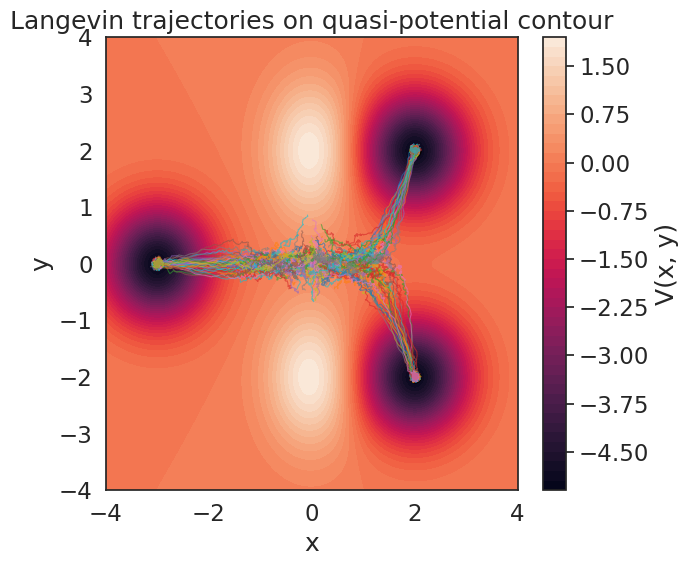

In [108]:


def V(x, y):
    barrier1 = B * np.exp(-(x**2/two_sx2 + (y+2)**2/two_sy2))
    barrier2 = B * np.exp(-(x**2/two_sx2 + (y-2)**2/two_sy2))
    wells_sum = sum(-well_depth * np.exp(-((x-xi)**2 + (y-yi)**2)/two_sw2)
                    for xi, yi in wells)
    return barrier1 + barrier2 + wells_sum

def grad_V(x, y):
    e1 = np.exp(-(x**2/two_sx2 + (y+2)**2/two_sy2))
    e2 = np.exp(-(x**2/two_sx2 + (y-2)**2/two_sy2))
    dVdx = B * (e1 + e2) * (-2 * x / two_sx2)
    dVdy = B * e1 * (-2 * (y+2) / two_sy2) + B * e2 * (-2 * (y-2) / two_sy2)
    for xi, yi in wells:
        e = np.exp(-((x-xi)**2 + (y-yi)**2)/two_sw2)
        dVdx += well_depth * e * (2 * (x-xi) / two_sw2)
        dVdy += well_depth * e * (2 * (y-yi) / two_sw2)
    return dVdx, dVdy

# --- Langevin parameters and initialization ----------------------------
D = 0.01
num_traj = 300
N_steps = 400
dt = 0.02
sqrt2Ddt = np.sqrt(2 * D * dt)

mean = [0.0, 0.0]
cov = [[0.1, 0], [0, 0.1]]
X0 = np.random.multivariate_normal(mean, cov, size=num_traj)

Xs = np.zeros((num_traj, N_steps))
Ys = np.zeros((num_traj, N_steps))
Xs[:, 0], Ys[:, 0] = X0[:, 0], X0[:, 1]

# --- Euler–Maruyama integration ----------------------------------------
for t in range(N_steps - 1):
    x_curr = Xs[:, t]
    y_curr = Ys[:, t]
    gx, gy = grad_V(x_curr, y_curr)
    Xs[:, t + 1] = x_curr - gx * dt + sqrt2Ddt * np.random.randn(num_traj)
    Ys[:, t + 1] = y_curr - gy * dt + sqrt2Ddt * np.random.randn(num_traj)

# --- Build mesh grid for contour plot -----------------------------------
xg = np.linspace(-4, 4, 500)
yg = np.linspace(-4, 4, 500)
Xg, Yg = np.meshgrid(xg, yg)
Zg = V(Xg, Yg)

# --- Collect snapshots at chosen time indices --------------------------
# times (indices) where to snapshot
snap_times = [0, 200, 300] # 200,
data_snap = {f"step_{t}": np.stack([Xs[:,t], Ys[:,t]], axis=1) for t in snap_times}

# Print shapes for verification
for label, arr in data_snap.items():
    print(f"{label}: {arr.shape}")

# --- 2‑D contour + trajectories ----------------------------------------
fig, ax = plt.subplots(figsize=(7, 6))
contours = ax.contourf(Xg, Yg, Zg, levels=60)
fig.colorbar(contours, label="V(x, y)")

# plot a subset of trajectories to avoid clutter
for i in range(100):
    ax.plot(Xs[i], Ys[i], linewidth=0.8, alpha=0.6)

# mark minima
for xm, ym in wells:
    ax.scatter([xm], [ym], marker='o', s=60, edgecolors='k')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Langevin trajectories on quasi‑potential contour")
plt.tight_layout()
plt.show()

In [109]:

p1 = np.sum( (data_snap[f'step_{snap_times[-1]}'][:,0] < 0) ) / num_traj
p2 = np.sum( (data_snap[f'step_{snap_times[-1]}'][:,0] > 2) & (data_snap[f'step_{snap_times[-1]}'][:,1] > 0)) / num_traj


In [110]:
p1

np.float64(0.4766666666666667)

In [111]:
p2

np.float64(0.11)

In [112]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float32


On device: cuda


In [113]:

C_factors_sequence = []

for i in range(len(snap_times) - 1):
    tp1 = data_snap[f'step_{snap_times[i]}']
    tp2 = data_snap[f'step_{snap_times[i+1]}']
    _X1 = torch.from_numpy(tp1).type(torch.DoubleTensor).to(device)
    _X2 = torch.from_numpy(tp2).type(torch.DoubleTensor).to(device)
    C12 = torch.cdist(_X1,  _X2).to(device)**2 #torch.cdist(_X1, _X2).to(device)
    C12 = C12.to(dtype)
    I = torch.eye(C12.shape[1]).to(dtype).to(device)
    C_factors_sequence.append(( C12, I ))



Iteration: 0
Iteration: 25
Initial Wasserstein cost: 5.530705451965332, GW-cost: 0, Total cost: 5.530705451965332
Final Wasserstein cost: 4.585109233856201, GW-cost: 0, Total cost: 4.585109233856201


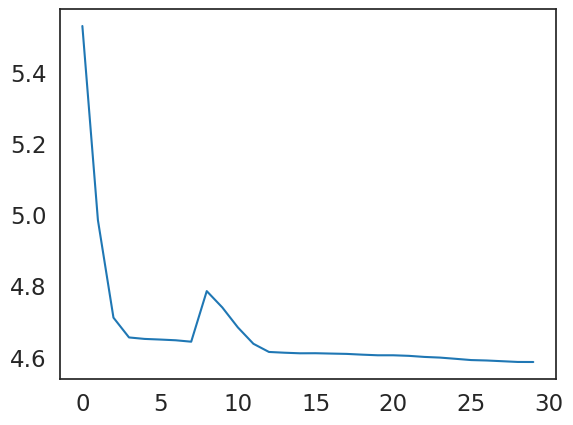

Iteration: 0
Iteration: 25
Initial Wasserstein cost: 5.484712600708008, GW-cost: 0, Total cost: 5.484712600708008
Final Wasserstein cost: 2.4351258277893066, GW-cost: 0, Total cost: 2.4351258277893066


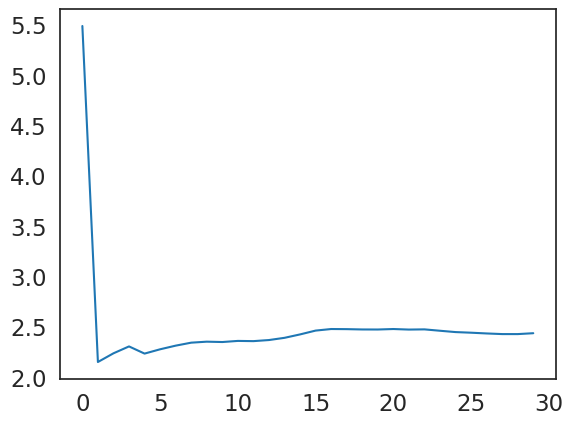

Iteration: 0
Iteration: 25
Initial Wasserstein cost: 5.63462495803833, GW-cost: 0, Total cost: 5.63462495803833
Final Wasserstein cost: 4.578489780426025, GW-cost: 0, Total cost: 4.578489780426025


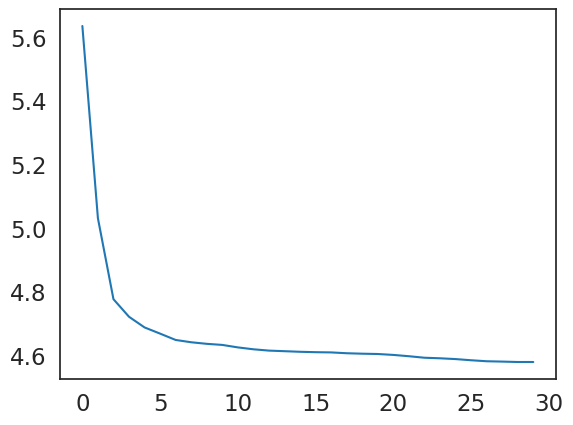

Ranks: r1 2, r2 5, r3 5
Iteration: 0
Iteration: 25
Initial Wasserstein-sum cost: 8.451322555541992
Final Wasserstein-sum cost: 6.206146240234375


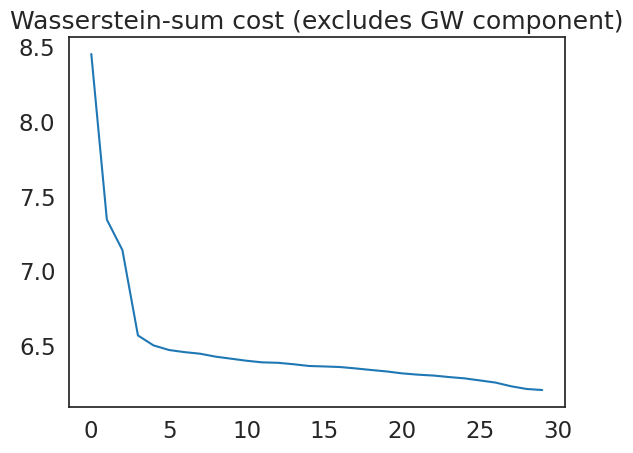

Iteration: 0
Iteration: 25
Initial Wasserstein cost: 4.7112274169921875, GW-cost: 0, Total cost: 4.7112274169921875
Final Wasserstein cost: 4.646636486053467, GW-cost: 0, Total cost: 4.646636486053467


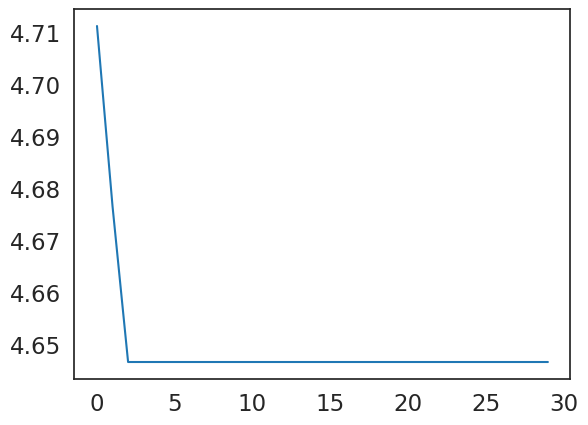

Iteration: 0
Iteration: 25
Initial Wasserstein cost: 1.5674186944961548, GW-cost: 0, Total cost: 1.5674186944961548
Final Wasserstein cost: 1.5644487142562866, GW-cost: 0, Total cost: 1.5644487142562866


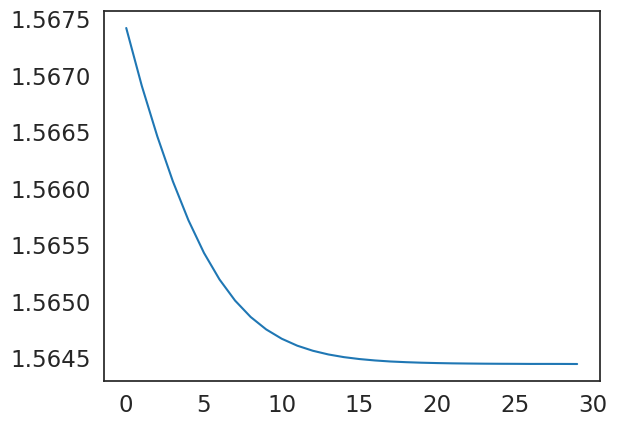

In [114]:
import sys
import os
sys.path.append(os.path.abspath(".."))
import src.HiddenMarkovOT as HiddenMarkovOT
import src.utils.clustering as clustering
import src.plotting as plotting
import importlib
importlib.reload(HiddenMarkovOT)

r = 5
rank_list = [(2,r)]
rank_list.extend([(r,r)]*(len(snap_times) - 2) )


iter = 30 #10
gamma = 80.0
alpha = 0.0
tau_in = 10
seed_everything(42)

# dirty guesstimate of proportions
props = [
    torch.tensor([p1, 1 - p1]).to(device).to(dtype)
        ]
props.extend( [torch.tensor([p1, p2, 1 - p1 - p2]).to(device).to(dtype)]*(len(snap_times) - 1) )

gen = torch.Generator(device=device)
gen.manual_seed(42)

hmot = HiddenMarkovOT.HM_OT(rank_list = rank_list,
                            max_iter = iter,
                            min_iter = iter,
                            device=device,
                            alpha = alpha,
                            gamma = gamma,
                            dtype = dtype,
                            printCost = True,
                            returnFull = False,
                            initialization = 'Full',
                            tau_in = tau_in,
                            max_inner_iters_R = 300,
                            generator = gen,
                            )

# proportions=props

A_factors_sequence = [None] * (len(snap_times))
hmot.gamma_smoothing(C_factors_sequence,
                    A_factors_sequence,
                    )


In [115]:
Qs = hmot.Q_gammas
Ts = hmot.T_gammas

Qs_np = [Q.cpu().detach().numpy() for Q in Qs]
Ts_np = [T.cpu().detach().numpy() for T in Ts]

Ss = [data_snap[f'step_{snap_times[i]}'] for i in range(len(snap_times))]

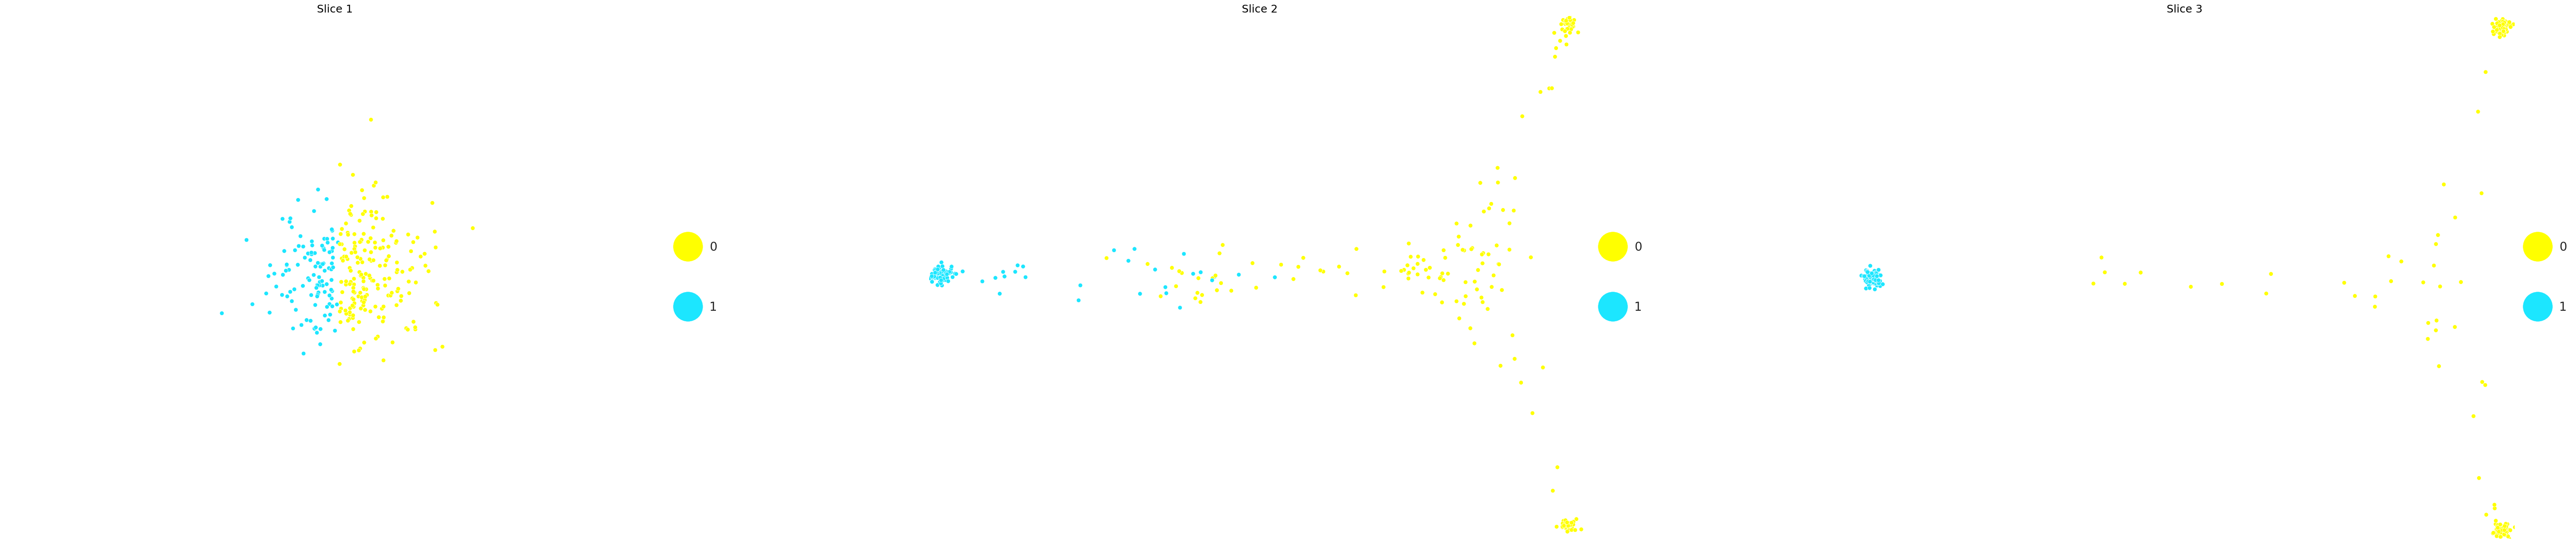

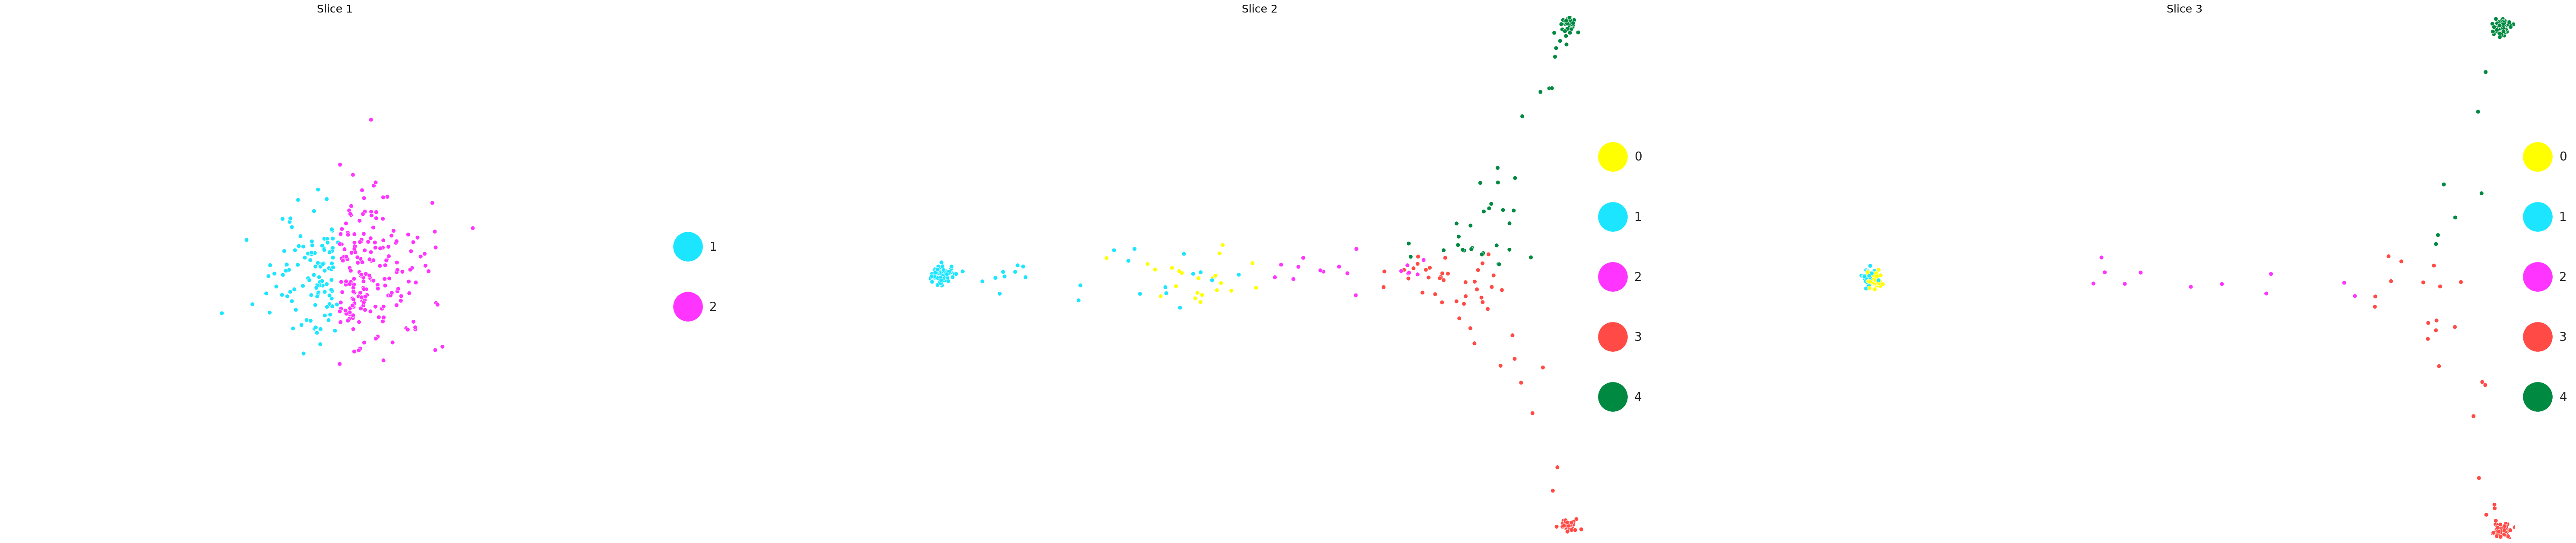

'\nclustering_1 = clustering.max_likelihood_clustering(\n                                Qs_np)'

In [116]:
plotting.plot_clusters_from_QT(Ss, Qs_np,
                               Ts_np, None, clustering_type='reference',
                               reference_index=0, flip=False, dotsize=50,
                              key_dotsize=1)

plotting.plot_clusters_from_QT(Ss, Qs_np,
                               Ts_np, None, clustering_type='reference',
                               reference_index=2, flip=False, dotsize=50,
                              key_dotsize=1)

'''
clustering_1 = clustering.reference_clustering(
                                Qs_np,
                                Ts_np,
                                reference_index=len(Qs_np)-1)'''

'''
clustering_1 = clustering.max_likelihood_clustering(
                                Qs_np)'''


(900, 2)


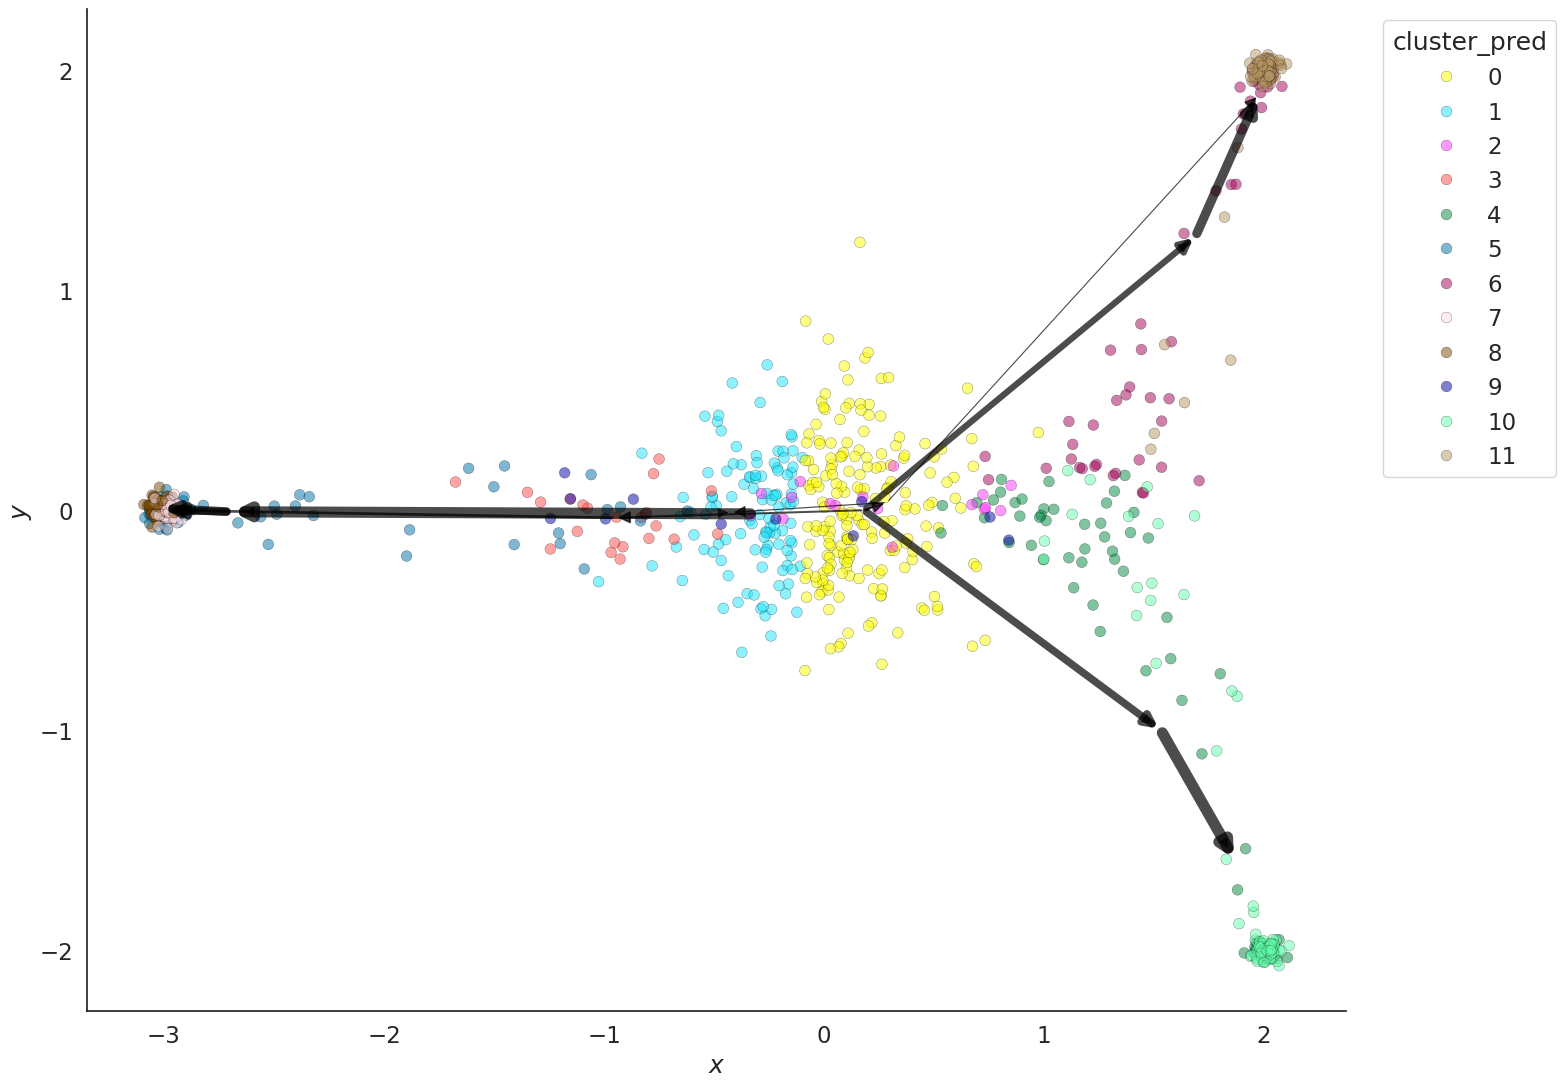

In [118]:


sys.path.append(os.path.abspath(".."))
import src.plotting as plotting 
import pandas as pd


Ss = [data_snap[f'step_{snap_times[i]}'] for i in range(len(snap_times))]

Ss_all = np.vstack(Ss)
print(Ss_all.shape)

n_per_time = Ss[0].shape[0]
time_labels = np.concatenate([[i] * n_per_time for i in range(len(snap_times))])

df = pd.DataFrame({
    "x": Ss_all[:, 0],
    "y": Ss_all[:, 1],
    "timepoint": time_labels
})

# Now call the plotting function
fig, ax = plotting.plot_diffmap_clusters_prime(
    X=Ss_all,                # point cloud (N_total x 2)
    time_labels=time_labels, # integer time labels
    Qs=Qs_np,                # list of Qs
    Ts=Ts_np,                # list of Ts
    df=df,                   # dataframe with "x", "y", "timepoint"
    cluster_key="cluster_pred"
)

plt.show()


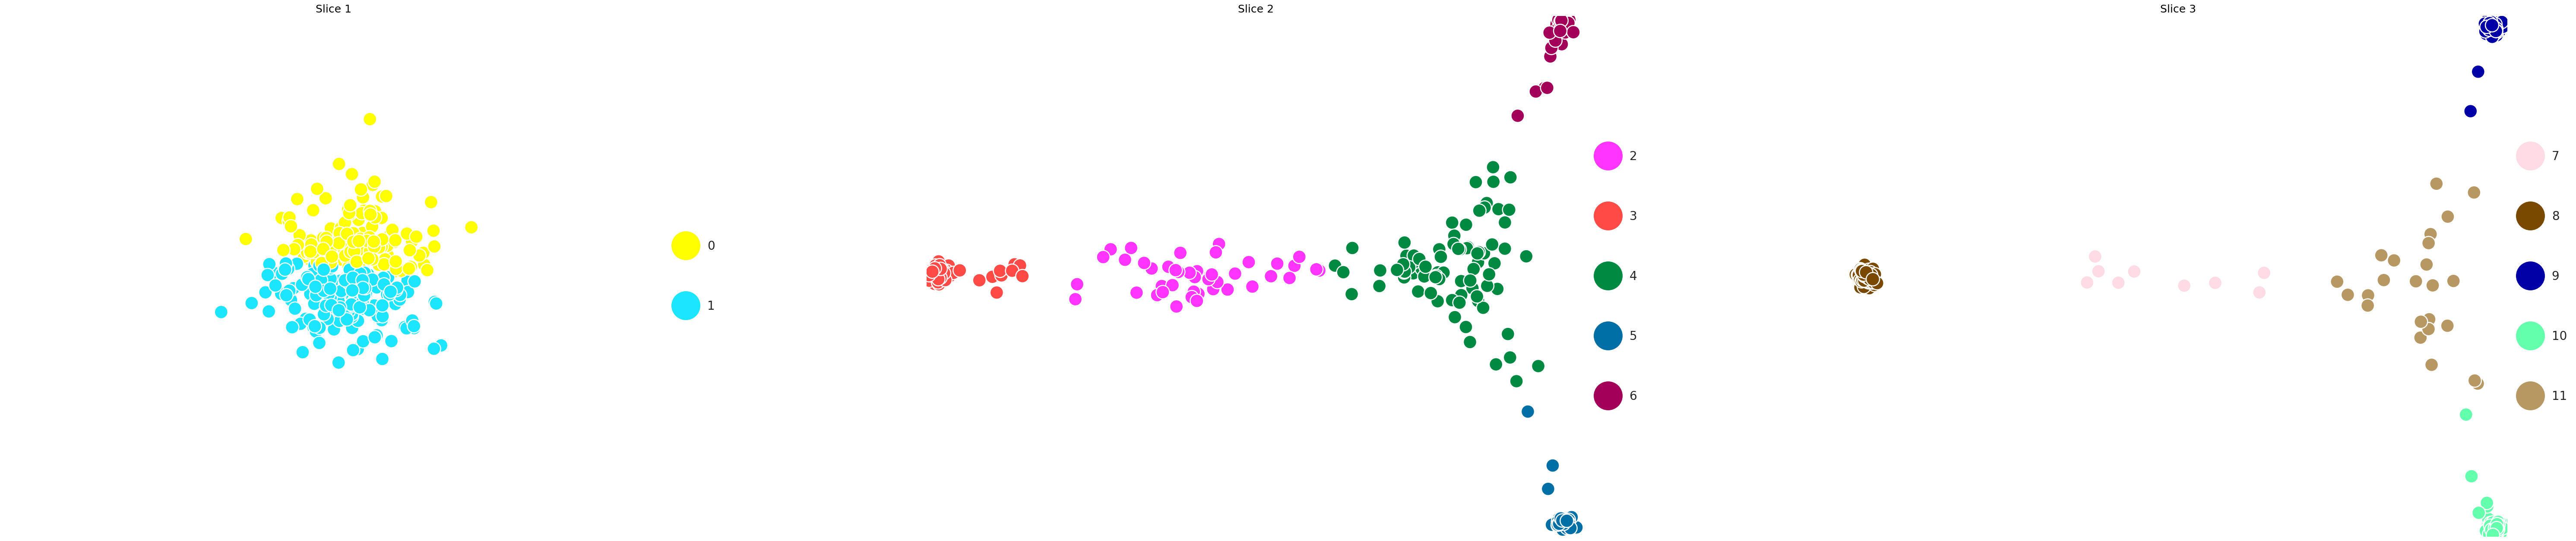

In [122]:
from sklearn.cluster import KMeans

kmeans1 = kmeans = KMeans(n_clusters=2,
                          random_state=42)
kmeans2 = kmeans = KMeans(n_clusters=5,
                          random_state=42)
kmeans3 = kmeans = KMeans(n_clusters=5,
                          random_state=42)

X1, X2, X3 = Ss

klabels1_ = kmeans1.fit_predict(X1)
klabels2_ = kmeans2.fit_predict(X2)
klabels3_ = kmeans3.fit_predict(X3)

klabels1 = klabels1_
klabels2 = klabels2_ + len(set(klabels1))
klabels3 = klabels3_ + len(set(klabels1)) + len(set(klabels2))

Q1_ann = np.eye(len(set(klabels1_)))[klabels1_]
Q2_ann = np.eye(len(set(klabels2_)))[klabels2_]
Q3_ann = np.eye(len(set(klabels3_)))[klabels3_]
Qs_ann = [Q1_ann, Q2_ann, Q3_ann]

#Ss = [X1, X2, X3]
cell_type_labels = np.concatenate([klabels1, klabels2, klabels3])

Ts = [None, None, None]
plotting.plot_clusters_from_QT(Ss, Qs_ann, Ts, dotsize=500)